In [0]:
from __future__ import print_function
import os
import numpy as np

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras.datasets import mnist

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
class VAE:
    
    def __init__(self, batch_size=1024, original_dim =1000, latent_dim = 10, epochs=50, root="IsingMC/", epsilon=0.5):
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = 380
        self.epochs = epochs
        self.epsilon_std = epsilon
    
    def sampling(self, args):
        ''' Sampling from the latent variables using the means and log-variances'''
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def build(self):
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim = self.intermediate_dim
        
        # encoder
        self.x = Input(shape=(original_dim,))
        h1 = Dense(intermediate_dim, activation='relu')(self.x)
        h2 = Dense(30, activation='relu')(h1)
        self.z_mean = Dense(latent_dim)(h2)
        self.z_log_var = Dense(latent_dim)(h2)
        
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])

        decoder_h1 = Dense(30, activation='relu')
        decoder_h2 = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded1 = decoder_h1(z)
        h_decoded2 = decoder_h2(h_decoded1)
        x_decoded_mean = decoder_mean(h_decoded2)
        
        #decoder
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded1 = decoder_h1(decoder_input)
        _h_decoded2 = decoder_h2(_h_decoded1)
        _x_decoded_mean = decoder_mean(_h_decoded2)
        
        self.generator = Model(decoder_input, _x_decoded_mean)
        
        self.vae = Model(self.x, x_decoded_mean)

        self.encoder = Model(self.x, self.z_mean)
        
        print(K.int_shape(x_decoded_mean),K.int_shape(self.z_mean),K.int_shape(self.x))

        self.vae.compile(optimizer='adam', loss=self.vae_loss)
        
        self.vae.summary()
        
    def vae_loss(self, x, x_decoded_mean):
            rms_loss = losses.mean_squared_error(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
            return rms_loss + kl_loss
        
    def train(self, x_train, x_test):
        from sklearn.preprocessing import minmax_scale, normalize
        
        x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flatten each sample out 
        x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        x_train = minmax_scale(x_train) 
        x_test = minmax_scale(x_train)
        
        
        self.vae.fit(x_train, x_train,
                shuffle=True,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, x_test)
                )
        
    def predict_latent(self, xnew):
        return self.encoder.predict(xnew)
    
    def generate_decoding(self, znew): 
        return self.generator.predict(znew)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')

In [23]:
Y=Y.T
print(np.shape(X),np.shape(Y))

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
X=(X-x_mean)/x_std


Y[Y[:,11]>2*np.pi,11]=Y[Y[:,11]>2*np.pi,11]-2*np.pi
Y[Y[:,11]<0,11]=Y[Y[:,11]<0,11]+2*np.pi
#Output[:,12:]=Output[:,12:]+2.0*np.pi

#Y=np.log(Y)
R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

#Standard Scaling of Y
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std
'''
#Min_Max Scaling of Y
y_min=np.min(Y,axis=0)
Y=Y-y_min
y_max=np.max(Y,axis=0)
Y=Y/y_max
'''

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

(1070107, 38) (1070107, 15)
(945049, 38) (945049, 15) (105006, 38) (105006, 15)


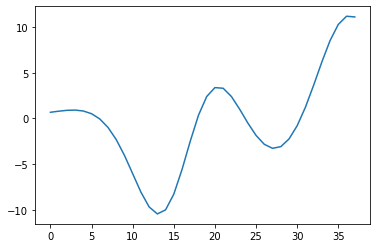

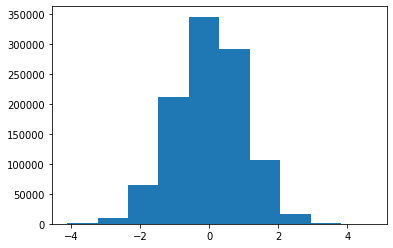

In [19]:
plt.plot(X[10000,:])
plt.show()
plt.hist(Y[:,8])
plt.show()

In [20]:
model = VAE(epochs=10, original_dim =38, latent_dim=2, epsilon=0.2) 
model.build() 
model.train(xtrain, xtest) 

(None, 38) (None, 2) (None, 38)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 380)          14820       input_3[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           11430       dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2)            62          dense_9[0][0]                    
____________________________________________________________

In [24]:
zpred = model.predict_latent(xtrain)
print(zpred.shape)

(945049, 2)


In [25]:
from mpl_toolkits.mplot3d import Axes3D 

golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

for i in range(15):
    plt.rc('font',**{'size':8})
    fig, ax = plt.subplots(1,figsize=golden_size(8))
    sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytrain[:,i], cmap="coolwarm",s=1)
    ax.set_xlabel('First latent dimension of the VAE')
    ax.set_ylabel('Second latent dimension of the VAE')
    plt.colorbar(sc)
    plt.draw()

Output hidden; open in https://colab.research.google.com to view.